# Bayesian Structural Time Series (BSTS) Model vs Traditional Time Series ARIMA Model For Sales Forecasting

#### In this example, the same synthetic generated sales data were used both in BSTS and ARIMA model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()
os.chdir('your-path')

In [ ]:
# Set up the environment
!pip install tensorflow tensorflow-probability matplotlib scikit-image

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import os
import shutil
from glob import glob

In [ ]:
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# Generate synthetic sales data
np.random.seed(42)
time = np.arange(100)
sales = 15 + 0.5 * time + 10 * np.sin(0.2 * time) + np.random.normal(scale=5.0, size=len(time))


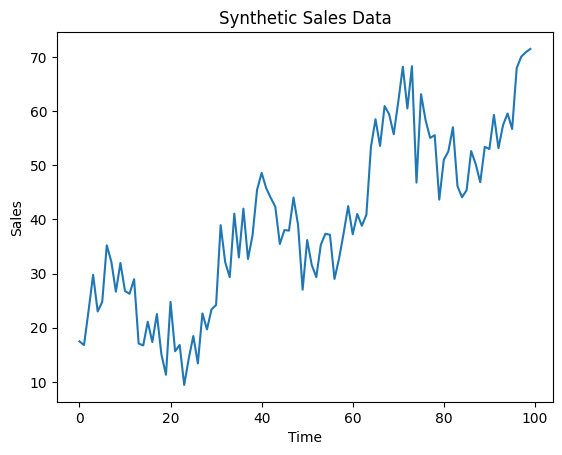

In [ ]:
# Plot the synthetic sales data
plt.plot(time, sales)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Synthetic Sales Data')
plt.show()

In [ ]:
# Define the Bayesian Structural Time Series Model

class BayesianStructuralTimeSeries(tf.keras.Model):
    def __init__(self):
        super(BayesianStructuralTimeSeries, self).__init__()
        self.loc = tf.Variable(0.0)
        self.scale = tfp.util.TransformedVariable(1.0, tfp.bijectors.Softplus())
        self.amplitude = tfp.util.TransformedVariable(1.0, tfp.bijectors.Softplus())
        self.frequency = tfp.util.TransformedVariable(0.1, tfp.bijectors.Softplus())

    def call(self, t):
        t = tf.cast(t, tf.float32)
        trend = self.loc + self.scale * t
        seasonality = self.amplitude * tf.sin(self.frequency * t)
        return trend + seasonality


In [ ]:
# Instantiate the model
bsts_model = BayesianStructuralTimeSeries()

In [ ]:
# Define the negative log likelihood loss function
def nll(y_true, y_pred):
    dist = tfd.Normal(loc=y_pred, scale=bsts_model.scale)
    return -tf.reduce_mean(dist.log_prob(y_true))


In [ ]:
# Compile the model
bsts_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=nll)

In [ ]:
# Train the model
bsts_model.fit(time, sales, epochs=1000, verbose=False)

In [ ]:
# Make BSTS predictions
time_forecast_bsts = np.arange(time[-1] + 1, time[-1] + 21)  # Starting right after the last historical time point
sales_forecast_bsts = bsts_model(time_forecast_bsts)

In [ ]:
# Combine time for plotting
combined_time_bsts = np.concatenate([time, time_forecast_bsts])
combined_sales_bsts = np.concatenate([sales, sales_forecast_bsts])

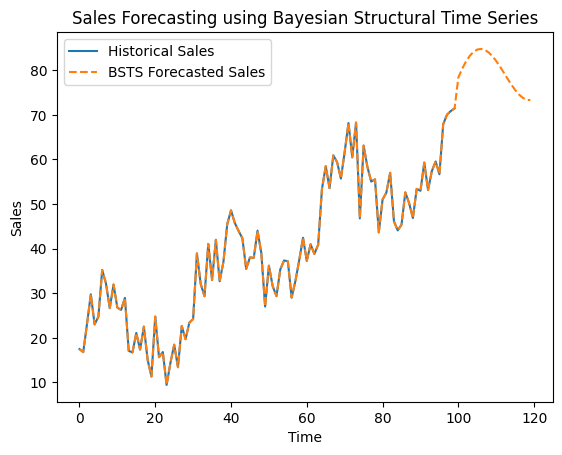

In [ ]:
# Plot the results
plt.plot(time, sales, label='Historical Sales')
plt.plot(combined_time_bsts, combined_sales_bsts, label='BSTS Forecasted Sales', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Forecasting using Bayesian Structural Time Series')
plt.legend()
plt.show()

In [ ]:
# Display Model Parameters
print(f"Trend Location: {bsts_model.loc.numpy()}")
print(f"Trend Scale: {bsts_model.scale.numpy()}")
print(f"Seasonality Amplitude: {bsts_model.amplitude.numpy()}")
print(f"Seasonality Frequency: {bsts_model.frequency.numpy()}")

Trend Location: 11.2177095413208
Trend Scale: 0.6039438843727112
Seasonality Amplitude: 10.120560646057129
Seasonality Frequency: 0.19582724571228027


# Time Series Sales Forecasting (with ARIMA)

In [ ]:
!pip install statsmodels

In [ ]:
#import libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Fit an ARIMA model to the generated above sales data.
# Convert to pandas Series
sales_series = pd.Series(sales)

In [ ]:
# Fit the ARIMA model
arima_model = SARIMAX(sales_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_model_fit = arima_model.fit(disp=False)

In [ ]:
# Print the model summary
print(arima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -291.502
Date:                            Sun, 23 Jun 2024   AIC                            593.005
Time:                                    15:25:15   BIC                            605.334
Sample:                                         0   HQIC                           597.969
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1564      0.246     -0.637      0.524      -0.638       0.325
ma.L1         -0.3727      0.239   

In [ ]:
# Make ARIMA predictions
forecast_steps = 20
arima_forecast = arima_model_fit.get_forecast(steps=forecast_steps)
arima_forecast_index = np.arange(time[-1] + 1, time[-1] + forecast_steps + 1)
arima_forecast_values = arima_forecast.predicted_mean
arima_forecast_conf_int = arima_forecast.conf_int()


In [ ]:
# Combine time for plotting
combined_time_arima = np.concatenate([time, arima_forecast_index])
combined_sales_arima = np.concatenate([sales, arima_forecast_values])

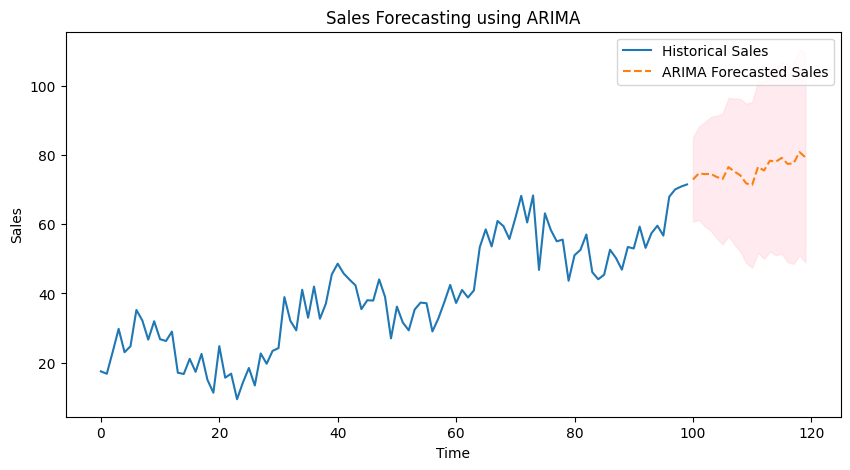

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(time, sales, label='Historical Sales')
plt.plot(arima_forecast_index, arima_forecast_values, label='ARIMA Forecasted Sales', linestyle='--')
plt.fill_between(arima_forecast_index, arima_forecast_conf_int.iloc[:, 0], arima_forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Forecasting using ARIMA')
plt.legend()
plt.show()

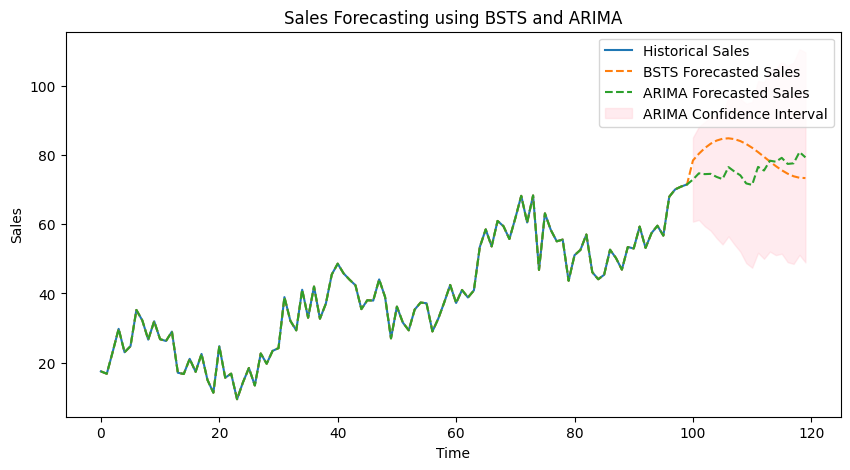

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time, sales, label='Historical Sales')
plt.plot(combined_time_bsts, combined_sales_bsts, label='BSTS Forecasted Sales', linestyle='--')
plt.plot(combined_time_arima, combined_sales_arima, label='ARIMA Forecasted Sales', linestyle='--')
plt.fill_between(arima_forecast_index, arima_forecast_conf_int.iloc[:, 0], arima_forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='ARIMA Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Forecasting using BSTS and ARIMA')
plt.legend()
plt.show()